### Усложняем динамику для Gravity_lens

Теперь:
r''_FCS = u_FCS - a_FCS - S^T * (S'' * r_FCS + 2 * S' * r'_FCS)

In [58]:
# !pip install stable_baselines3
# !pip install numpy


In [59]:
import sys
sys.path.append("C:/Users/snr/kiam_rl")

import numpy as np
from datetime import datetime
import stable_baselines3
from rl_routines import RLProblem, Environment
from rl_routines import ActorCriticNetworks, get_CustomActorCriticPolicy
from rl_routines import evaluate_policy, statistics
import gymnasium as gym
import numpy 
from numpy.linalg import norm
from stable_baselines3 import PPO
import torch
import math
import random
import matplotlib.pyplot as plt
import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from torch.utils.tensorboard import SummaryWriter
from scipy.integrate import solve_ivp

In [60]:
from Dynamics_SGLF import Dynamics_SGLF

In [61]:
""" параметры задачи """
R0 = 100_000. / 1.496e8 #радиус круга, который является областью начальных условий, a.e.
z = 550. # расстояние от Солнца до начального положения КА на фокальной линии, a.e. 
z0 = 10. * 63241.1  # расстояние от Солнца до барицентра экзосистемы, а.е.
V_0 = 25. # а.е./год, скорость аппарата в инерц системе
DT = 0.05 # Шаг для t_span
t0_data = datetime(2030, 9, 1, 0, 0) # начало отсчета, дата
n_imp = 6 # число импульсов за эпизод
delta_v_max = 100. / 4740.57 # ограничение скорости импульса агента , а.е./год
tfinal = 30. / 365.25 # длительность эпизода, год
#delta_t_imp = tfinal / n_imp  #интервал между импульсами, год
alfa = 1. # весовая константа в выражении для функции вознаграждения, (????)
threshold = 10_000. / 1.496e8 # радиус круга-цели на плоскости Oyx, a.e.
total_timesteps = 15000 # общее количество шагов во время обучения модели
t0 = 0.
V_0 = 25. # скорость аппарата в инерц системе в начальный момент, а.е./год

# Орбитальные параметры экзопланеты
Orb_param_exo_array = np.array([
    1. ,  # большая полуось (а.е)
    1. ,  # период обращения (годы)
    0.0167086,  # эксцентриситет
    -240., 352.5, 37.5,  # аргументы орбиты (град)
    datetime(2021, 1, 2)  # начальное время (дата)
])

# Массы тел (в кг)
M_sun = 1.989 * 1e30  # масса Солнца (кг)
M_JSUN_array = np.array([
    1.8982e27,  # Юпитер (кг)
    5.6834e26,  # Сатурн
    8.6810e25,  # Уран
    1.02413e26  # Нептун
])

# Орбитальные параметры планет-гигантов
Orb_param_JSUN_array = np.array([
    [5.2044 , 11.862 , 0.0489, 100.464, 273.867, 1.303, datetime(2023, 1, 21)],  #[a, T, e, Omega, w, i, t0]
    [9.5826 , 29.4571 , 0.0565, 113.665, 339.392, 2.485, datetime(2032, 11, 29)],
    [19.2184 , 84.0205 , 0.046381, 74.006, 96.998857, 0.773, datetime(2050, 8, 19)],
    [30.07, 164.8 , 0.008678, 131.784, 276.336, 1.767957, datetime(2042, 9, 4)]])



In [62]:
class Dynamics_Problem(RLProblem):
    def __init__(self, R0, tfinal, n_imp, delta_v_max, alfa, threshold, t0, t0_data, z0):
        """
        единица расстояния: 1 а.е.
        единица скорости: 1 а.е.
        единица времени: 1 год
        """
        super().__init__()
        self.R0 = R0 # a.e.
        self.tfinal = tfinal # годы
        self.n_imp = n_imp
        self.time_step = self.tfinal / self.n_imp #интервал между импульсами, год
        self.delta_v_max = delta_v_max # a.e. / год
        self.alfa = alfa # ???
        self.threshold = threshold # a.e.
        self.t0 = t0 # начало отсчета, год
        self.z0 = z0 # a.e.
        self.nostep = 0 
        self.t0_data = t0_data
        self.dynamics = Dynamics_SGLF(Orb_param_exo_array, M_sun, M_JSUN_array, Orb_param_JSUN_array, self.t0, self.t0_data, self.z0)
        
    @property
    def observation_space(self):  
        return gym.spaces.Box(low=numpy.array([-numpy.inf, -numpy.inf, -numpy.inf, -numpy.inf, -numpy.inf, -numpy.inf]),  
                              high=numpy.array([numpy.inf , numpy.inf, numpy.inf, numpy.inf, numpy.inf, numpy.inf]), 
                              dtype=numpy.float64)
    
    @property
    def action_space(self):  
        return gym.spaces.Box(low=-1, high=1, shape=(3,), dtype=numpy.float32)
    
    def initialize(self):
        """
        Инициализация начального положения и времени.
        Генерация начального состояния аппарата в соответствии с условиями:
        z0 = 550 a.e.
        r0 = [x0, y0, z0], v0 = [0, 0, V0], где x0^2 + y0^2 ≤ R0^2.
        
        Returns
        -------
        t0 : float
            Начальный момент времени (обычно 0).
        x0 : np.ndarray, shape (6,)
            Начальный фазовый вектор (положение и скорость).
            Начальное положение выбирается из области: y0^2 + z0^2 ≤ R0^2.
        """
        S = self.dynamics.basis_FCS(t = 0.)[0]
        dS_dt, d2S_dt = self.dynamics.dS_dt(t=0.)
        dRdt_SSB_0, d2Rd2t_SSB_0 = self.dynamics.r_sun_deriv(t = 0.)
        self.nostep = 0
        while True:
            x0 = numpy.random.uniform(-self.R0, self.R0) 
            y0 = numpy.random.uniform(-self.R0, self.R0)
            if x0**2 + y0**2 <= self.R0**2:
                break
        
        p0_FCS = np.array([x0, y0, self.z0])
        drdt_SSB_0 = 25. * S[:, 2]
        dpdt_FCS_0 = S.T @ (drdt_SSB_0 - dRdt_SSB_0 - dS_dt @ p0_FCS)
        X0 = np.concatenate((p0_FCS, dpdt_FCS_0))
        self.x_old = X0.copy()
        return 0.0, X0
    
    def action2u(self, action):
        """
        Функция, переводящая выход стратегии (нейросети) в импульс.
        Проверяет, что импульс удовлетворяет ограничениям.
        Возвращает импульс (в виде массива [dVx, dVy, dVz]).

        dV: float
            лежит в [-0.1; 0.1]
        """
        delta_v = action * min(1, self.delta_v_max / numpy.linalg.norm(action))
        return delta_v
    
    def Dynamics(self, t):
        """
        Возвращает матрицу S и вторую производную по времени от r_sun.
        """
        dynamics = self.dynamics
        dr_sun_dt, d2r_sun_dt = dynamics.r_sun_deriv(t)  
        S, a_vec = dynamics.basis_FCS(t)  
        dS_dt, d2S_dt = dynamics.dS_dt(t)  
        return S, dS_dt, d2S_dt, d2r_sun_dt, a_vec

    def equations_of_motion(self, t, x):
        """
        Возвращает правую часть уравнений движения dx/dt = f(t, x, u)
        Для текущей задачи размерность x равна 6
        x' = (v, f)

        Parameters
        ----------
        t : float
            Текущий момент времени
        x : np.ndarray, shape(6,)
            Текущий фазовый вектор x = (r, v)
        
        Returns
        -------
        dx/dt(t, x) : np.ndarray, shape(6,)
            Правая часть уравнений.
            Импульсы тут НЕ учитываются
        """
        S, dS_dt, d2S_dt, d2r_sun_dt_SSB, a_vec = self.Dynamics(t) 

        p_FCS = x[:3] 
        dpdt_FCS = x[3:]

        D = d2S_dt @ p_FCS + 2 * (dS_dt @ dpdt_FCS)
        d2pdt2_FCS = - S @ d2r_sun_dt_SSB - S.T @ D
        return numpy.concatenate((dpdt_FCS, d2pdt2_FCS), axis=0) 

    def step(self, t, x, delta_v):
        """
        Шаг моделирования: агент применяет импульс, и состояние обновляется.
        """
        self.x_old = x.copy()
        self.nostep += 1
        x_new = x.copy().astype(numpy.float64)  # Гарантируем, что x_new будет массивом float64
        
        # Применяем изменение скорости
        x_new[3:6] += delta_v  
        
        # Численное интегрирование
        sol = solve_ivp(self.equations_of_motion, (t, t + self.time_step), x_new, method='RK45', t_eval=[t + self.time_step])
        
        x_new = sol.y[:, -1]  # + delta_v

        terminated = False
        truncated = self.nostep >= self.n_imp 
        return t + self.time_step, x_new, terminated, truncated

    def rho(self, X):
        """Вычисляет значение ρ(x) по формуле: sqrt(y^2 + z^2) + α * sqrt( (v_y^2 + v_z^2))"""
        x = X[0]
        y = X[1]  # Компоненты позиции
        vx = X[3]
        vy = X[4]  # Компоненты скорости
        return numpy.sqrt((x)**2 + (y)**2)  + self.alfa * numpy.sqrt(vy**2 + vx**2) 

    def reward(self, t, x_new, delta_v, terminated, truncated):
        reward = 0
        # Вычисляем ρ(x_k) и ρ(x_(k+1))
        rho_old = self.rho(self.x_old)
        rho_new = self.rho(x_new)
        # Вознаграждение за улучшение расстояния (уменьшение ρ)
        r_k = rho_old - rho_new
        reward += r_k
        return reward
    
    def perception_model(self, t, x):   
        return x

problem_with_dynamics = Dynamics_Problem(R0=R0, tfinal = tfinal, n_imp = n_imp, delta_v_max = delta_v_max, alfa = alfa, threshold = threshold, t0=t0, t0_data=t0_data, z0=z0)

env_with_dynamics = DummyVecEnv([lambda: Monitor(Environment(problem_with_dynamics))])


In [63]:
import torch.nn as nn
class Dynamics_ActorCriticNetworks(ActorCriticNetworks):
    def __init__(self, feature_dim):
        """
        feature_dim: размерность входных данных (наблюдений), должно быть 6
        hidden_dim: размер скрытого слоя (n1), должно быть = 1
        """
        last_layer_dim_pi = 6
        last_layer_dim_vf = 6
        super().__init__(feature_dim, last_layer_dim_pi = last_layer_dim_pi, last_layer_dim_vf = last_layer_dim_vf)

        # Policy network (π)
        self.policy_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_pi),  # Aπ1 * o + bπ1
            nn.Tanh(),
        )

        # Value network (V)
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_vf),  # Av1 * o + bv1
            nn.Tanh(),
        )
Gravity_ActorCriticNetworks = get_CustomActorCriticPolicy(Dynamics_ActorCriticNetworks)

In [64]:
device = 'cpu'  

init_choice = input("Выберите тип инициализации весов ('z' - нули, 'r' - случайные, 'f' - из файла): ").strip().lower()

# Функция для инициализации весов нулями
def initialize_weights_zeros(model):
    for m in model.policy.children():
        if isinstance(m, nn.Linear):
            nn.init.constant_(m.weight, 0.0)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)
    print("Веса инициализированы нулями.")

# Функция для инициализации случайными весами
def initialize_weights_random(model):
    for m in model.policy.parameters():
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.uniform_(m.weight, -0.1, 0.1)  # Инициализация весов
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.0)  # Инициализация смещений

# Создание модели
model = PPO(
    Gravity_ActorCriticNetworks,
    env_with_dynamics,
    n_steps=10000,  
    batch_size=10000, 
    n_epochs=30, 
    learning_rate=0.001, 
    verbose=2,
    device=device,
    tensorboard_log='Dynamics_SGLF',
    policy_kwargs={'log_std_init': -5.},
    gamma=0.95
)

if init_choice == 'z':
    initialize_weights_zeros(model)
elif init_choice == 'r':
    initialize_weights_random(model)
elif init_choice == 'f':
    weights_file = input("Введите путь к файлу весов: ").strip()
    if os.path.exists(weights_file):
        model = PPO.load(weights_file, env=env_with_dynamics)
        print(f"Веса загружены из {weights_file}.")
    else:
        print(f"Файл {weights_file} не найден. Используются стандартные начальные веса.")
else:
    print("Используются стандартные начальные веса.")


Using cpu device


In [ ]:
# Обучение модели
model.learn(total_timesteps=total_timesteps)

Logging to Dynamics_SGLF\PPO_12


In [ ]:
def my_statistics(x):
    q0 = numpy.quantile(x, 0.00)
    q1 = numpy.quantile(x, 0.10)
    q2 = numpy.quantile(x, 0.20)
    q3 = numpy.quantile(x, 0.30)
    q4 = numpy.quantile(x, 0.40)
    q5 = numpy.quantile(x, 0.50)
    q6 = numpy.quantile(x, 0.60)
    q7 = numpy.quantile(x, 0.70)
    q8 = numpy.quantile(x, 0.80)
    q9 = numpy.quantile(x, 0.90)
    q10 = numpy.quantile(x, 1.00)
    # mean = numpy.mean(x)
    # std = numpy.std(x)
    # cv = mean / std
    return q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 # , mean, std, cv

from stable_baselines3.common.evaluation import evaluate_policy
episode_rewards, episode_lengths = evaluate_policy(
    model, model.get_env(), n_eval_episodes=10, return_episode_rewards=True, render=False)

print(my_statistics(episode_rewards))

(-1.043759, -1.0437509, -1.0437459999999998, -1.0436218, -1.0435222, -1.0434565, -1.0433404, -1.0431937, -1.0430782, -1.0428291, -1.042704)


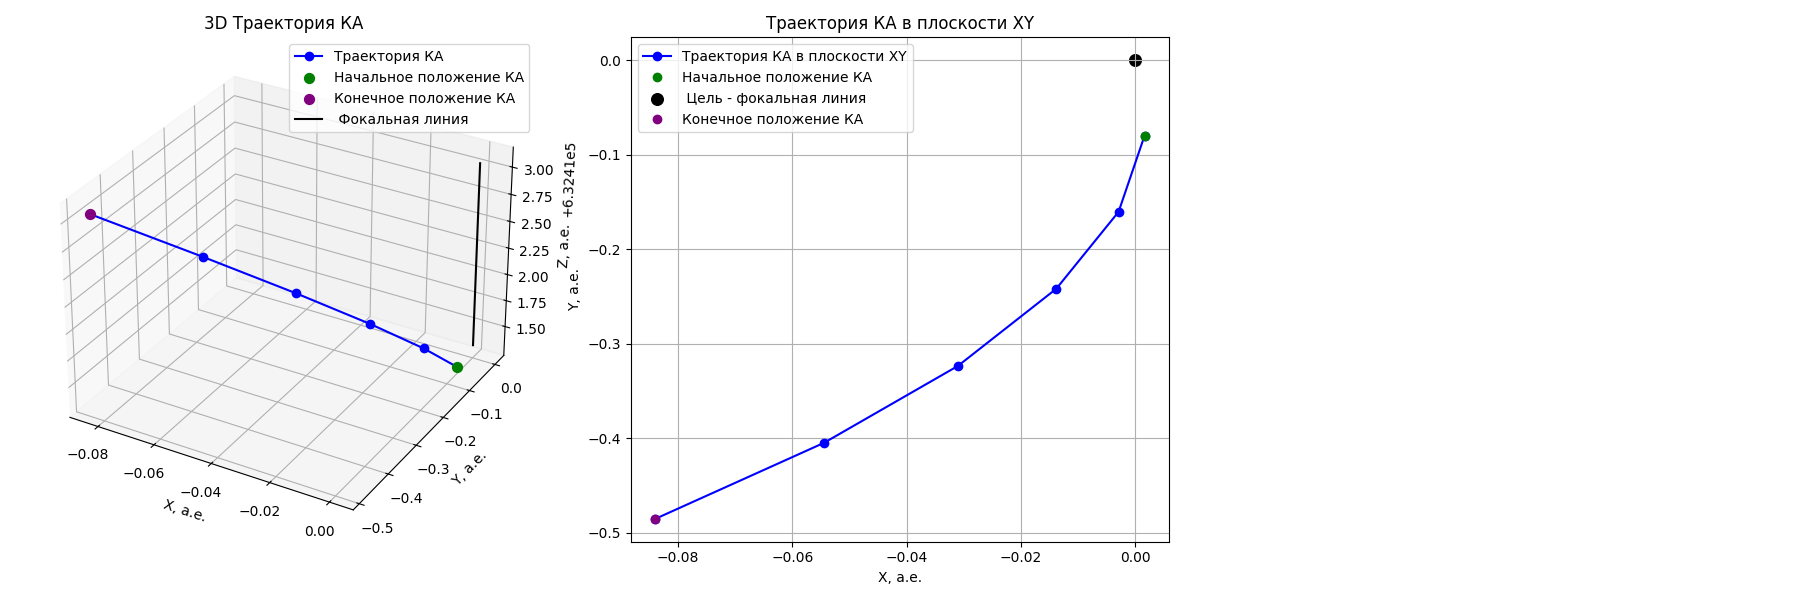

In [ ]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Получение окружения и начальных наблюдений
vec_env = model.get_env()
obs = vec_env.reset()

# Инициализация списков для хранения данных
action_array = []
states_array = []
obs_array = []
rewards_array = []
reward_total = 0
reward_total_array = []

for i in range(n_imp):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = vec_env.step(action)
    
    if dones[0]:  # Если эпизод завершен
        obs_array.append(info[0]['terminal_observation'])
        rewards = np.array(info[0]['episode']['r'])
        reward_total_array.append(rewards)
        break

    reward_total += rewards
    obs_array.append(obs[0, :])
    rewards_array.append(rewards)
    reward_total_array.append(reward_total[0])
    action_array.append(action)
    states_array.append(_states)

# Преобразование списков в массивы
action_array = np.array(action_array)
states_array = np.array(states_array)
obs_array = np.array(obs_array)

# Извлекаем координаты из фазового вектора
x_array = obs_array[:, 0]  # Координата x
y_array = obs_array[:, 1]  # Координата y
z_array = obs_array[:, 2]  # Координата z

# Извлекаем компоненты скорости
vx_array = obs_array[:, 3]
vy_array = obs_array[:, 4]
vz_array = obs_array[:, 5]

# Создание графиков
fig = plt.figure(figsize=(18, 6))

# 3D-график траектории
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(x_array, y_array, z_array, '-o', color='blue', label='Траектория КА')
ax1.scatter(x_array[0], y_array[0], z_array[0], color="green", label="Начальное положение КА", s=50)
ax1.scatter(x_array[-1], y_array[-1], z_array[-1], color="purple", label="Конечное положение КА", s=50)
ax1.plot([0, 0], [0, 0],[np.min(z_array), np.max(z_array)], '-', color='black', label=' Фокальная линия')
ax1.set_title('3D Траектория КА')
ax1.set_xlabel('X, а.е.')
ax1.set_ylabel('Y, а.е.')
ax1.set_zlabel('Z, а.е.')
ax1.legend()

# 2D-график в плоскости (y, z)
ax2 = fig.add_subplot(132)
ax2.plot(x_array, y_array, '-o', color='blue', label='Траектория КА в плоскости XY')
ax2.plot(x_array[0], y_array[0], 'o', color="green", label="Начальное положение КА")
ax2.scatter([0.], [0.], color = 'black', s = 70, label = " Цель - фокальная линия")
ax2.plot(x_array[-1], y_array[-1], 'o', color="purple", label="Конечное положение КА")
ax2.set_title('Траектория КА в плоскости XY')
ax2.set_xlabel('X, а.е.')
ax2.set_ylabel('Y, а.е.')
ax2.legend()
ax2.grid()

# # График скоростей (Vy, Vx)
# ax3 = fig.add_subplot(133)
# ax3.plot(vz_array, '-o', color='red', label='Vx')
# ax3.plot(vy_array, '-o', color='blue', label='Vy')
# ax3.set_title('График скорости')
# ax3.set_xlabel('Шаги')
# ax3.set_ylabel('Скорость')
# ax3.legend()
# ax3.grid()

plt.tight_layout()
plt.show()
